⚠️ **Static Version Notice**

This is a static export of an interactive marimo notebook. Some features have been modified for compatibility:

- Interactive UI elements (sliders, dropdowns, text inputs) have been removed
- UI variable references have been replaced with default values
- Some cells may have been simplified or removed entirely

For the full interactive experience, please run the original marimo notebook (.py file) using:
```bash
uv run marimo edit notebook_name.py
```

---


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F


In [33]:
# Prepare the Data
transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', download=False, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', download=False, transform=transform)

In [34]:
BATCH_SIZE = 64
IMAGE_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [35]:
first_image, first_label = train_dataset[0]
print(first_image.shape)


torch.Size([3, 32, 32])


Label:  6


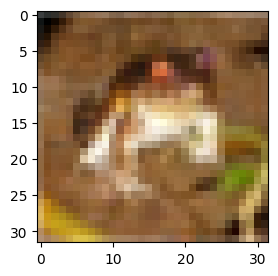

In [36]:
def show_image(image, label=None):
    print("Label: ", label)
    plt.figure(figsize=(4, 3)) 
    plt.imshow(image.permute(1,2,0).squeeze(), cmap='gray')
    plt.show()
show_image(first_image, first_label)


Let's take $x_0$ to be a random variable representing images in our data distribution. We will assume that it has mean $0$ and variance $1$. This is ok since we have preprocessed the training images to have mean $0$ and variance $1$.

Next, we will corrupt the images by adding standard gaussian noise $\epsilon$ (mean 0, variance 1). How much noise should be added?

To keep the transformed distribution having the same mean and variance, we can control the noise amount using a parameter $\beta$:

$x_1 = \sqrt{1-\beta}x_0 + \sqrt{\beta} \epsilon$

Then if $x_0$ has mean $0$ and variance $1$, $x_1$ will have mean:

$\sqrt{1-\beta}*0+\sqrt{\beta}*0=0$

and variance:

$(\sqrt{1-\beta})^2*1 + (\sqrt{\beta})^2*1=1-\beta+\beta=1$.

In [37]:
def corrupt_image(image, beta = 0.1):
    image_with_noise = np.sqrt(1-beta)*image + np.sqrt(beta)*np.random.normal(0, 1, image.shape)
    return image_with_noise
# show_image(corrupt_image(first_image))


How does changing $\beta$ influence the amount of noise added to the image?  Try to find a value that makes the image look like a random noise image.  You can use the slider below to change the value of $\beta$.

In [38]:
import math

class SinusoidalEmbedding(nn.Module):
    def __init__(self, num_frequencies=16):
        super().__init__()
        self.num_frequencies = num_frequencies
        frequencies = torch.exp(torch.linspace(math.log(1.0), math.log(1000.0), num_frequencies))
        self.register_buffer("angular_speeds", 2.0 * math.pi * frequencies.view(1, 1, 1, -1))

    def forward(self, x):
        """
        x: Tensor of shape (B, 1, 1, 1)
        returns: Tensor of shape (B, 1, 1, 2 * num_frequencies)
        """
        x = x.expand(-1, 1, 1, self.num_frequencies)
        sin_part = torch.sin(self.angular_speeds * x)
        cos_part = torch.cos(self.angular_speeds * x)
        return torch.cat([sin_part, cos_part], dim=-1)         


In [39]:
def linear_diffusion_schedule(diffusion_times, min_rate=1e-4, max_rate=0.02):
    """
    diffusion_times: Tensor of shape (T,) with values in [0, 1)
    Returns:
        noise_rates: Tensor of shape (T,)
        signal_rates: Tensor of shape (T,)
    """
    diffusion_times = diffusion_times.to(dtype=torch.float32)
    betas = min_rate + diffusion_times * (max_rate - min_rate)
    alphas = 1.0 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)

    signal_rates = torch.sqrt(alpha_bars)
    noise_rates = torch.sqrt(1.0 - alpha_bars)
    return noise_rates, signal_rates


def cosine_diffusion_schedule(diffusion_times):
    # diffusion_times: Tensor of shape [T] or [B] with values in [0, 1]
    signal_rates = torch.cos(diffusion_times * math.pi / 2)
    noise_rates = torch.sin(diffusion_times * math.pi / 2)
    return noise_rates, signal_rates

def offset_cosine_diffusion_schedule(diffusion_times, min_signal_rate=0.02, max_signal_rate=0.95):
    # Flatten diffusion_times to handle any shape
    original_shape = diffusion_times.shape
    diffusion_times_flat = diffusion_times.flatten()

    # Compute start and end angles from signal rate bounds
    start_angle = torch.acos(torch.tensor(max_signal_rate, dtype=torch.float32, device=diffusion_times.device))
    end_angle = torch.acos(torch.tensor(min_signal_rate, dtype=torch.float32, device=diffusion_times.device))

    # Linearly interpolate angles
    diffusion_angles = start_angle + diffusion_times_flat * (end_angle - start_angle)

    # Compute signal and noise rates
    signal_rates = torch.cos(diffusion_angles).reshape(original_shape)
    noise_rates = torch.sin(diffusion_angles).reshape(original_shape)

    return noise_rates, signal_rates



In [40]:
images, _ = next(iter(train_loader))
noises = torch.randn(size=(BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE))

diffusion_times = torch.rand((BATCH_SIZE,), device=images.device)  # scalar per sample
diffusion_times = diffusion_times.view(BATCH_SIZE, 1, 1, 1)         # for broadcasting

noise_rates, signal_rates = linear_diffusion_schedule(diffusion_times)
noisy_images = signal_rates * images + noise_rates * noises



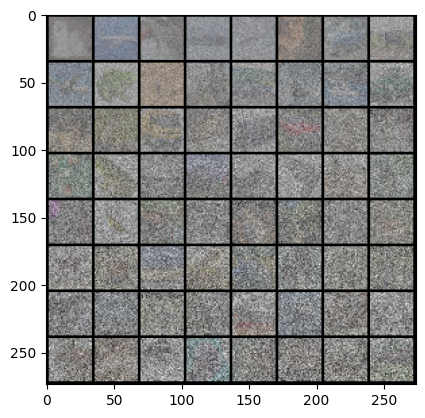

In [41]:
from torchvision.utils import make_grid
grid = make_grid(noisy_images, normalize=True)
plt.imshow(grid.permute(1, 2, 0))


Next we build the three new layers used in a UNet neural network, a popular architecture used in Diffusion Models.

In [42]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.needs_projection = in_channels != out_channels
        if self.needs_projection:
            self.proj = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.proj = nn.Identity()

        self.norm = nn.BatchNorm2d(in_channels, affine=False)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def swish(self, x):
        return x * torch.sigmoid(x)

    def forward(self, x):
        residual = self.proj(x)
        # x = self.norm(x)
        x = self.swish(self.conv1(x))
        x = self.conv2(x)
        return x + residual

class DownBlock(nn.Module):
    def __init__(self, width, block_depth, in_channels):
        super().__init__()
        self.blocks = nn.ModuleList()
        for i in range(block_depth):
            self.blocks.append(ResidualBlock(in_channels, width))
            in_channels = width
        self.pool = nn.AvgPool2d(kernel_size=2)

    def forward(self, x, skips):
        for block in self.blocks:
            x = block(x)
            skips.append(x)
        x = self.pool(x)
        return x

class UpBlock(nn.Module):
    def __init__(self, width, block_depth, in_channels):
        super().__init__()
        self.blocks = nn.ModuleList()
        for _ in range(block_depth):
            self.blocks.append(ResidualBlock(in_channels + width, width))
            in_channels = width

    def forward(self, x, skips):
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        for block in self.blocks:
            skip = skips.pop()
            x = torch.cat([x, skip], dim=1)
            x = block(x)
        return x




In [43]:
class UNet(nn.Module):
    def __init__(self, image_size, num_channels, embedding_dim=32):
        super().__init__()
        self.initial = nn.Conv2d(num_channels, 32, kernel_size=1)
        self.num_channels = num_channels
        self.image_size = image_size
        self.embedding_dim = embedding_dim
        self.embedding = SinusoidalEmbedding(num_frequencies=16)
        self.embedding_proj = nn.Conv2d(embedding_dim, 32, kernel_size=1)

        self.down1 = DownBlock(32, in_channels=64, block_depth=2)
        self.down2 = DownBlock(64, in_channels=32, block_depth=2)
        self.down3 = DownBlock(96, in_channels=64, block_depth=2) 

        self.mid1 = ResidualBlock(in_channels=96, out_channels=128)
        self.mid2 = ResidualBlock(in_channels=128, out_channels=128)

        self.up1 = UpBlock(96, in_channels=128, block_depth=2) 
        self.up2 = UpBlock(64, block_depth=2, in_channels=96)
        self.up3 = UpBlock(32, block_depth=2, in_channels=64)

        self.final = nn.Conv2d(32, num_channels, kernel_size=1)
        nn.init.zeros_(self.final.weight)  # Keep zero init like TF reference

    def forward(self, noisy_images, noise_variances):
        skips = []
        x = self.initial(noisy_images)
        noise_emb = self.embedding(noise_variances)  # shape: (B, 1, 1, 32)
        # Upsample to match image size like TF reference
        noise_emb = F.interpolate(noise_emb.permute(0, 3, 1, 2), size=(self.image_size, self.image_size), mode='nearest')
        x = torch.cat([x, noise_emb], dim=1)

        x = self.down1(x, skips)
        x = self.down2(x, skips) 
        x = self.down3(x, skips)    

        x = self.mid1(x)     
        x = self.mid2(x)   

        x = self.up1(x, skips)
        x = self.up2(x, skips)
        x = self.up3(x, skips)

        return self.final(x)


In [44]:
import copy

class DiffusionModel(nn.Module):
    def __init__(self, model, schedule_fn):
        super().__init__()
        self.network = model
        self.ema_network = copy.deepcopy(model)
        self.ema_network.eval()
        self.ema_decay = 0.8
        self.schedule_fn = schedule_fn
        self.normalizer_mean = 0.0
        self.normalizer_std = 1.0

    def to(self, device):
        # Override to() to ensure both networks move to the same device
        super().to(device)
        self.ema_network.to(device)
        return self

    def set_normalizer(self, mean, std):
        self.normalizer_mean = mean
        self.normalizer_std = std

    def denormalize(self, x):
        return torch.clamp(x * self.normalizer_std + self.normalizer_mean, 0.0, 1.0)

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        # Use EMA network for inference, main network for training
        if training:
            network = self.network
            network.train()
        else:
            network = self.ema_network
            network.eval()

        pred_noises = network(noisy_images, noise_rates ** 2)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        step_size = 1.0 / diffusion_steps
        current_images = initial_noise
        for step in range(diffusion_steps):
            t = torch.ones((initial_noise.shape[0], 1, 1, 1), device=initial_noise.device) * (1 - step * step_size)
            noise_rates, signal_rates = self.schedule_fn(t)
            pred_noises, pred_images = self.denoise(current_images, noise_rates, signal_rates, training=False)

            # Debug generation process
            if step % max(1, diffusion_steps // 4) == 0:  # Print 4 times during generation
                print(f"Generation Step {step}/{diffusion_steps}: t={1-step*step_size:.3f}")
                print(f"  Current images std: {current_images.std().item():.4f}")
                print(f"  Pred images std: {pred_images.std().item():.4f}")
                print(f"  Signal rate: {signal_rates.mean().item():.4f}, Noise rate: {noise_rates.mean().item():.4f}")

            next_diffusion_times = t - step_size
            next_noise_rates, next_signal_rates = self.schedule_fn(next_diffusion_times)
            current_images = next_signal_rates * pred_images + next_noise_rates * pred_noises
        return pred_images

    def generate(self, num_images, diffusion_steps, image_size=64, initial_noise=None):
        if initial_noise is None:
            initial_noise = torch.randn((num_images, self.network.num_channels, image_size, image_size), device=next(self.parameters()).device)
        with torch.no_grad():
            return self.denormalize(self.reverse_diffusion(initial_noise, diffusion_steps))

    def train_step(self, images, optimizer, loss_fn):
        images = (images - self.normalizer_mean) / self.normalizer_std
        noises = torch.randn_like(images)

        diffusion_times = torch.rand((images.size(0), 1, 1, 1), device=images.device)
        noise_rates, signal_rates = self.schedule_fn(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noises

        pred_noises, _ = self.denoise(noisy_images, noise_rates, signal_rates, training=True)
        loss = loss_fn(pred_noises, noises)

        # Debug prints
        if torch.rand(1).item() < 0.01:  # Print more frequently to see output
            print(f"Debug - Loss: {loss.item():.4f}, Noise std: {noises.std().item():.4f}, Pred std: {pred_noises.std().item():.4f}")
            print(f"Signal rates range: {signal_rates.min().item():.4f}-{signal_rates.max().item():.4f}")
            print(f"Noise rates range: {noise_rates.min().item():.4f}-{noise_rates.max().item():.4f}")

        optimizer.zero_grad()
        loss.backward()

        # Check for gradient issues
        if torch.rand(1).item() < 0.01:
            total_norm = 0
            for p in self.network.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
            print(f"Gradient norm: {total_norm:.4f}")

        optimizer.step()

        with torch.no_grad():
            # Debug EMA update occasionally
            if torch.rand(1).item() < 0.001:
                param_diff = 0
                for ema_param, param in zip(self.ema_network.parameters(), self.network.parameters()):
                    param_diff += (ema_param - param).abs().mean().item()
                print(f"EMA Update Debug - Avg param difference: {param_diff:.6f}")

            for ema_param, param in zip(self.ema_network.parameters(), self.network.parameters()):
                ema_param.copy_(self.ema_decay * ema_param + (1. - self.ema_decay) * param)

        return loss.item()

    def test_step(self, images, loss_fn):
        images = (images - self.normalizer_mean) / self.normalizer_std
        noises = torch.randn_like(images)

        diffusion_times = torch.rand((images.size(0), 1, 1, 1), device=images.device)
        noise_rates, signal_rates = self.schedule_fn(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noises

        with torch.no_grad():
            pred_noises, _ = self.denoise(noisy_images, noise_rates, signal_rates, training=False)
            loss = loss_fn(pred_noises, noises)

        return loss.item()

    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6):
        # plot random generated images for visual evaluation of generation quality
        generated_images = self.generate(
            num_images=num_rows * num_cols,
            image_size=IMAGE_SIZE,
            diffusion_steps=20,
        ).cpu()
        show_image(generated_images[0])      


The training loop looks similar to the one used in the previous modules.

In [45]:
from tqdm import tqdm
import os

def train_diffusion(model, train_loader, val_loader, optimizer, loss_fn, epochs=50, device='cuda', checkpoint_dir='checkpoints'):
    # Create checkpoint directory
    os.makedirs(checkpoint_dir, exist_ok=True)

    model.to(device)
    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        train_losses = []
        loader_with_progress = tqdm(train_loader, ncols=120, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        for images, _  in loader_with_progress:
            images = images.to(device)
            loss = model.train_step(images, optimizer, loss_fn)
            train_losses.append(loss)
            loader_with_progress.set_postfix(loss=f'{loss:.4f}')

        avg_train_loss = sum(train_losses) / len(train_losses)

        model.eval()
        model.plot_images()

        val_losses = []
        for images, _ in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            images = images.to(device)
            loss = model.test_step(images, loss_fn)
            val_losses.append(loss)

        avg_val_loss = sum(val_losses) / len(val_losses)
        loader_with_progress.set_postfix(loss=f'{avg_train_loss:.4f}')

        # Save checkpoint every epoch
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.network.state_dict(),
            'ema_model_state_dict': model.ema_network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'normalizer_mean': model.normalizer_mean,
            'normalizer_std': model.normalizer_std
        }

        # Save latest checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f'diffusion_epoch_{epoch+1:03d}.pth')
        torch.save(checkpoint, checkpoint_path)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_checkpoint_path = os.path.join(checkpoint_dir, 'diffusion_best.pth')
            torch.save(checkpoint, best_checkpoint_path)
            print(f"New best model saved at epoch {epoch+1} with val_loss: {avg_val_loss:.4f}")

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        print(f"Checkpoint saved: {checkpoint_path}")

def load_checkpoint(model, optimizer, checkpoint_path, device='cuda'):
    """
    Load a saved checkpoint and restore model, EMA, and optimizer states
    """
    checkpoint = torch.load(checkpoint_path, map_location=device)

    model.network.load_state_dict(checkpoint['model_state_dict'])
    model.ema_network.load_state_dict(checkpoint['ema_model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Restore normalizer settings
    model.normalizer_mean = checkpoint['normalizer_mean']
    model.normalizer_std = checkpoint['normalizer_std']

    print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
    print(f"Train Loss: {checkpoint['train_loss']:.4f}, Val Loss: {checkpoint['val_loss']:.4f}")

    return checkpoint['epoch']



In [46]:
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {device}')

Using device: cpu


Normalization stats - Mean: tensor([0.4914, 0.4822, 0.4465]) Std: tensor([0.2464, 0.2428, 0.2607])


Epoch 1/2 [Train]:   1%|▍                                                  | 6/782 [00:12<23:52,  1.85s/it, loss=0.7866]

EMA Update Debug - Avg param difference: 0.121687


Epoch 1/2 [Train]:  12%|██████                                            | 95/782 [02:20<27:27,  2.40s/it, loss=0.2742]

Gradient norm: 0.4693


Epoch 1/2 [Train]:  15%|███████▏                                         | 114/782 [02:47<14:51,  1.33s/it, loss=0.3102]

Gradient norm: 0.4514


Epoch 1/2 [Train]:  34%|████████████████▊                                | 268/782 [08:53<20:48,  2.43s/it, loss=0.2271]

Debug - Loss: 0.2189, Noise std: 1.0014, Pred std: 0.9377
Signal rates range: 0.0555-0.9489
Noise rates range: 0.3157-0.9985


Epoch 1/2 [Train]:  41%|███████████████████▊                             | 317/782 [11:26<25:35,  3.30s/it, loss=0.2329]

Gradient norm: 0.4675


Epoch 1/2 [Train]:  47%|██████████████████████▊                          | 365/782 [14:03<18:17,  2.63s/it, loss=0.1878]

Debug - Loss: 0.1956, Noise std: 0.9992, Pred std: 0.9682
Signal rates range: 0.0386-0.9452
Noise rates range: 0.3265-0.9993


Epoch 1/2 [Train]:  51%|█████████████████████████▏                       | 402/782 [14:56<10:12,  1.61s/it, loss=0.2118]

Gradient norm: 0.6838


Epoch 1/2 [Train]:  64%|███████████████████████████████▎                 | 500/782 [18:10<11:40,  2.48s/it, loss=0.2096]

Debug - Loss: 0.2062, Noise std: 0.9994, Pred std: 0.9544
Signal rates range: 0.0302-0.9490
Noise rates range: 0.3153-0.9995


Epoch 1/2 [Train]:  66%|████████████████████████████████▏                | 514/782 [18:43<10:49,  2.42s/it, loss=0.1776]

Gradient norm: 0.2847


Epoch 1/2 [Train]:  69%|█████████████████████████████████▋               | 538/782 [19:44<12:02,  2.96s/it, loss=0.1884]

Debug - Loss: 0.2138, Noise std: 1.0004, Pred std: 0.9500
Signal rates range: 0.0520-0.9459
Noise rates range: 0.3246-0.9986


Epoch 1/2 [Train]:  72%|███████████████████████████████████▏             | 561/782 [20:56<06:55,  1.88s/it, loss=0.2025]

Gradient norm: 0.3636


Epoch 1/2 [Train]:  75%|████████████████████████████████████▋            | 585/782 [21:44<06:18,  1.92s/it, loss=0.1980]

Debug - Loss: 0.1950, Noise std: 1.0004, Pred std: 0.9636
Signal rates range: 0.0205-0.9347
Noise rates range: 0.3555-0.9998


Epoch 1/2 [Train]:  79%|██████████████████████████████████████▋          | 617/782 [22:42<04:31,  1.64s/it, loss=0.1975]

Gradient norm: 0.3081


Epoch 1/2 [Train]:  83%|████████████████████████████████████████▍        | 646/782 [23:37<03:55,  1.73s/it, loss=0.2110]

Gradient norm: 0.6117


Epoch 1/2 [Train]:  89%|███████████████████████████████████████████▋     | 698/782 [25:09<02:01,  1.45s/it, loss=0.1853]

Debug - Loss: 0.2013, Noise std: 1.0008, Pred std: 0.9608
Signal rates range: 0.0982-0.9478
Noise rates range: 0.3188-0.9952


Epoch 1/2 [Train]:  97%|███████████████████████████████████████████████▎ | 756/782 [27:04<00:42,  1.64s/it, loss=0.1913]

Debug - Loss: 0.1734, Noise std: 1.0008, Pred std: 0.9627
Signal rates range: 0.0285-0.9453
Noise rates range: 0.3261-0.9996


Epoch 1/2 [Train]: 100%|█████████████████████████████████████████████████| 782/782 [27:52<00:00,  2.14s/it, loss=0.1489]


Generation Step 0/20: t=1.000
  Current images std: 0.9971
  Pred images std: 2.8329
  Signal rate: 0.0200, Noise rate: 0.9998
Generation Step 5/20: t=0.750
  Current images std: 1.1205
  Pred images std: 1.6052
  Signal rate: 0.3224, Noise rate: 0.9466
Generation Step 10/20: t=0.500
  Current images std: 1.3190
  Pred images std: 1.6367
  Signal rate: 0.5945, Noise rate: 0.8041
Generation Step 15/20: t=0.250
  Current images std: 1.5067
  Pred images std: 1.6494
  Signal rate: 0.8105, Noise rate: 0.5858
Label:  None


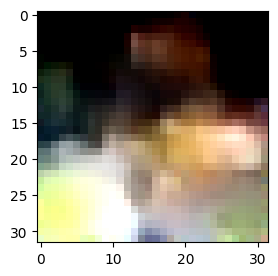

Epoch 1 [Val]: 100%|███████████████████████████████████████████████████████████████████| 782/782 [06:30<00:00,  2.00it/s]


New best model saved at epoch 1 with val_loss: 0.1894
Epoch 1 | Train Loss: 0.2559 | Val Loss: 0.1894
Checkpoint saved: checkpoints\diffusion_epoch_001.pth


Epoch 2/2 [Train]:  18%|████████▊                                        | 141/782 [04:48<15:37,  1.46s/it, loss=0.2059]

Debug - Loss: 0.1912, Noise std: 0.9983, Pred std: 0.9631
Signal rates range: 0.0278-0.9490
Noise rates range: 0.3151-0.9996


Epoch 2/2 [Train]:  20%|█████████▉                                       | 158/782 [05:34<24:51,  2.39s/it, loss=0.1854]

Debug - Loss: 0.1916, Noise std: 1.0013, Pred std: 0.9632
Signal rates range: 0.0336-0.9402
Noise rates range: 0.3405-0.9994


Epoch 2/2 [Train]:  23%|███████████▎                                     | 181/782 [06:19<15:38,  1.56s/it, loss=0.2120]

Debug - Loss: 0.1861, Noise std: 0.9996, Pred std: 0.9640
Signal rates range: 0.0611-0.9433
Noise rates range: 0.3318-0.9981


Epoch 2/2 [Train]:  49%|████████████████████████▏                        | 386/782 [13:33<14:29,  2.20s/it, loss=0.2016]

Debug - Loss: 0.2122, Noise std: 0.9984, Pred std: 0.9616
Signal rates range: 0.0237-0.9418
Noise rates range: 0.3361-0.9997


Epoch 2/2 [Train]:  57%|███████████████████████████▉                     | 445/782 [15:30<09:33,  1.70s/it, loss=0.1768]

Gradient norm: 0.2057


Epoch 2/2 [Train]:  59%|████████████████████████████▉                    | 461/782 [16:05<13:50,  2.59s/it, loss=0.1738]

In [ ]:
NOISE_EMBEDDING_SIZE = 64
NUM_CHANNELS = 3
unet = UNet(IMAGE_SIZE, NUM_CHANNELS, NOISE_EMBEDDING_SIZE)
diffusion_model = DiffusionModel(unet, offset_cosine_diffusion_schedule)

optimizer = torch.optim.AdamW(diffusion_model.network.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.L1Loss()

# Calculate proper per-channel normalization statistics
mean = torch.zeros(NUM_CHANNELS)
std = torch.zeros(NUM_CHANNELS)
total_samples = 0

train_loader_for_stats = DataLoader(train_dataset, batch_size=BATCH_SIZE)
for imgs, _ in train_loader_for_stats:
    batch_size = imgs.size(0)
    # Reshape to (batch_size, channels, height*width)
    imgs_flat = imgs.view(batch_size, NUM_CHANNELS, -1)

    # Calculate mean and std per channel across all pixels in this batch
    batch_mean = imgs_flat.mean(dim=(0, 2))  # Mean across batch and spatial dims
    batch_std = imgs_flat.std(dim=(0, 2))    # Std across batch and spatial dims

    # Accumulate statistics
    mean += batch_mean * batch_size
    std += batch_std * batch_size
    total_samples += batch_size

# Finalize statistics
mean /= total_samples
std /= total_samples

print("Normalization stats - Mean:", mean, "Std:", std)
mean = mean.reshape(1, NUM_CHANNELS, 1, 1).to(device)
std = std.reshape(1, NUM_CHANNELS, 1, 1).to(device)
diffusion_model.set_normalizer(mean, std)
# To load from a checkpoint, uncomment and specify the path:
# load_checkpoint(diffusion_model, optimizer, 'checkpoints/diffusion_epoch_010.pth', device=device)

train_diffusion(diffusion_model, train_loader, test_loader, optimizer, loss_fn, epochs=2, device=device)

In [ ]:
# Generate images
diffusion_model.eval()
samples = diffusion_model.generate(num_images=1, image_size=IMAGE_SIZE, diffusion_steps=1000)  # returns tensor in [0, 1]

# Convert to numpy for plotting
image = samples[0].cpu()

# Plot
show_image(image)


In [ ]:
# Test EMA after training
test_input = torch.randn(1, 3, 64, 64).to(device)
test_noise_var = torch.tensor([[[[0.5]]]]).to(device)
